In [2]:
import os
import gc
import feature_engineering.technical_indicators as ti
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from utils.ffill_impute import ffill_impute
from utils.get_kaggle import sync_and_save_parquet
from pathlib import Path
from utils.vif import remove_high_vif

# Cleaning and Exploration

### Download Parquet files

In [3]:
DATASET_SLUG = "braydenmcarthur/10x-crypto-ohlcv-2024-2025"

try:
    sync_and_save_parquet(DATASET_SLUG)
except Exception as e:
    print(f"Error: {e}")

Fetching latest data from Kaggle: braydenmcarthur/10x-crypto-ohlcv-2024-2025...


100%|██████████| 38.7M/38.7M [00:00<00:00, 81.7MB/s]

Extracting files...


Syncing 10 files to /home/zoltesh/projects/intelligent_diversification/src/data...
 -> Updated DOGE-USDC.parquet
 -> Updated XRP-USDC.parquet
 -> Updated BTC-USDC.parquet
 -> Updated BCH-USDC.parquet
 -> Updated LINK-USDC.parquet
 -> Updated ADA-USDC.parquet
 -> Updated LTC-USDC.parquet
 -> Updated ETH-USDC.parquet
 -> Updated SOL-USDC.parquet
 -> Updated AVAX-USDC.parquet

Sync Complete. Files are located in: /home/zoltesh/projects/intelligent_diversification/src/data


### Create the lazyframes

In [4]:
ada_lf = pl.scan_parquet('data/ADA-USDC.parquet')
avax_lf = pl.scan_parquet('data/AVAX-USDC.parquet')
bch_lf = pl.scan_parquet('data/BCH-USDC.parquet')
btc_lf = pl.scan_parquet('data/BTC-USDC.parquet')
doge_lf = pl.scan_parquet('data/DOGE-USDC.parquet')
eth_lf = pl.scan_parquet('data/ETH-USDC.parquet')
link_lf = pl.scan_parquet('data/LINK-USDC.parquet')
ltc_lf = pl.scan_parquet('data/LTC-USDC.parquet')
sol_lf = pl.scan_parquet('data/SOL-USDC.parquet')
xrp_lf = pl.scan_parquet('data/XRP-USDC.parquet')

all_lf = {
    'ADA': ada_lf,
    'AVAX': avax_lf,
    'BCH': bch_lf,
    'BTC': btc_lf,
    'DOGE': doge_lf,
    'ETH': eth_lf,
    'LINK': link_lf,
    'LTC': ltc_lf,
    'SOL': sol_lf,
    'XRP': xrp_lf
}

### Identify sparsity

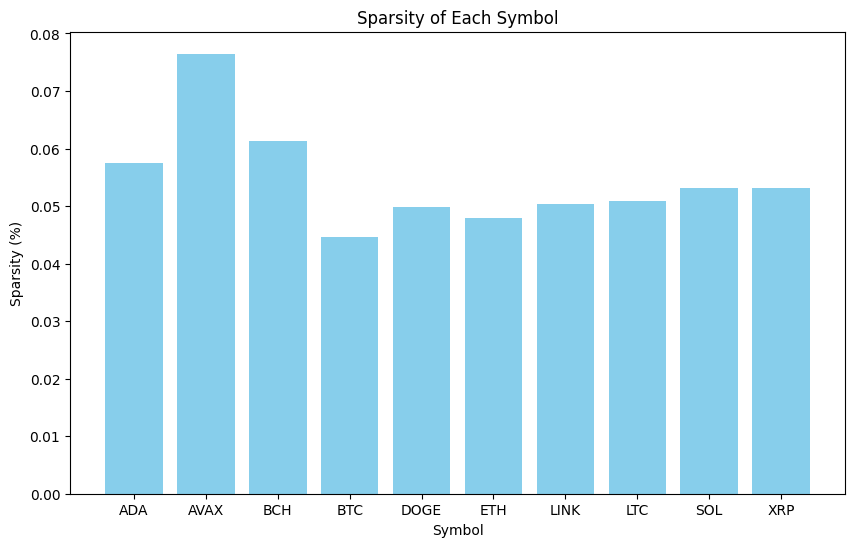

Average sparsity: 0.05%


In [10]:
# Print percentage missing out of 210,528 rows per file

sparsity_dict = {symbol: 0.0 for symbol in all_lf.keys()}

total_rows = 0
total_missing = 0
for symbol, lf in all_lf.items():
    rows = lf.select(pl.len()).collect().item()
    missing = (210_528 - rows) / 210_528 * 100
    total_missing += missing
    total_rows += rows
    sparsity_dict[symbol] = missing

avg_sparsity = (2_105_280 - total_rows) / 2_105_280 * 100

# Plot barchart of sparsity
plt.figure(figsize=(10, 6))
plt.bar(sparsity_dict.keys(), sparsity_dict.values(), color='skyblue')
plt.xlabel('Symbol')
plt.ylabel('Sparsity (%)')
plt.title('Sparsity of Each Symbol')
plt.show()
print(f"Average sparsity: {avg_sparsity:.2f}%")


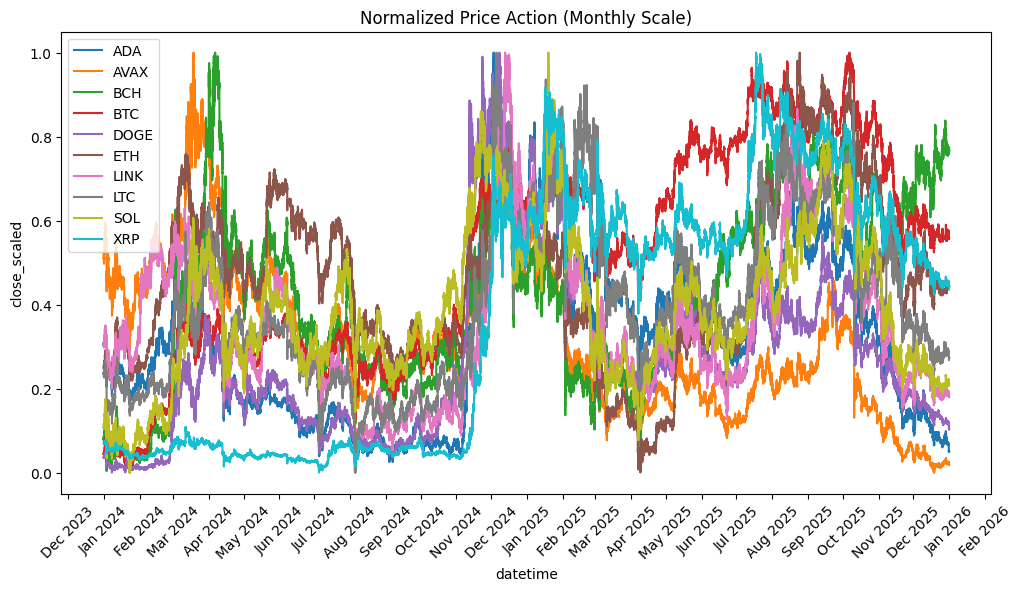

In [7]:
# Set up the plot frame
fig, ax = plt.subplots(figsize=(12, 6))

for symbol, lf in all_lf.items():
    # 1. Cast timestamp to Datetime & Scale Price
    df = lf.with_columns([
        pl.col("timestamp").cast(pl.Datetime('ms')).alias("datetime"),
        ((pl.col("close") - pl.col("close").min()) / 
         (pl.col("close").max() - pl.col("close").min())).alias("close_scaled")
    ]).collect()
    
    # 2. Plot
    sns.lineplot(x='datetime', y='close_scaled', data=df, label=symbol, ax=ax)

# 3. Configure the X-Axis for Monthly Buckets
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Label the ticks (e.g., "Jan 2024")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate dates for readability
plt.xticks(rotation=45)
plt.title("Normalized Price Action (Monthly Scale)")
plt.show()

# Detect any gaps/missing timestamp and forward fill them

In [8]:
OUT_DIR = Path("data_cleaned")
OUT_DIR.mkdir(parents=True, exist_ok=True)

for symbol, lf in all_lf.items():
    out_lf, imputed = ffill_impute(lf, every="5m")
    out_path = OUT_DIR / f"{symbol}-USDC.parquet"
    out_lf.sink_parquet(out_path)
    print(f"{symbol}: imputed {imputed} rows -> {out_path}")

ADA: imputed 121 rows -> data_cleaned/ADA-USDC.parquet
AVAX: imputed 161 rows -> data_cleaned/AVAX-USDC.parquet
BCH: imputed 129 rows -> data_cleaned/BCH-USDC.parquet
BTC: imputed 94 rows -> data_cleaned/BTC-USDC.parquet
DOGE: imputed 105 rows -> data_cleaned/DOGE-USDC.parquet
ETH: imputed 101 rows -> data_cleaned/ETH-USDC.parquet
LINK: imputed 106 rows -> data_cleaned/LINK-USDC.parquet
LTC: imputed 107 rows -> data_cleaned/LTC-USDC.parquet
SOL: imputed 112 rows -> data_cleaned/SOL-USDC.parquet
XRP: imputed 112 rows -> data_cleaned/XRP-USDC.parquet


### Ensure:
### - Rows = 210528
### - No Duplicates
### - No Gaps
### - No Nulls
### - Status OK

In [11]:
CLEANED_DIR = Path("data_cleaned")
STEP_MS = 300_000  # 5 minutes

print(f"{'File':<20} | {'Rows':>8} | {'DupTS':>5} | {'Gaps':>4} | {'Nulls':>5} | {'Status'}")
print("-" * 70)

for path in sorted(CLEANED_DIR.glob("*.parquet")):
    df = pl.read_parquet(path).select(["timestamp", "open", "high", "low", "close", "volume"]).sort("timestamp")

    ts = df["timestamp"]
    d = ts.diff().drop_nulls()

    has_gaps = not (d == STEP_MS).all()
    has_dups = ts.n_unique() != ts.len()

    # expected row count for a perfectly continuous series over [min, max]
    expected_rows = int((ts.max() - ts.min()) // STEP_MS + 1)
    wrong_count = df.height != expected_rows

    nulls = int(df.null_count().sum_horizontal().item())

    status = "OK" if (nulls == 0 and not has_gaps and not has_dups and not wrong_count) else "ERROR"
    print(f"{path.name:<20} | {df.height:>8} | {str(has_dups):>5} | {str(has_gaps):>4} | {nulls:>5} | {status}")

    if status == "ERROR":
        # show the first few offending deltas
        bad = df.select(
            pl.col("timestamp"),
            pl.col("timestamp").diff().alias("dt"),
        ).filter(pl.col("dt").is_not_null() & (pl.col("dt") != STEP_MS)).head(10)
        if bad.height:
            print(bad)

File                 |     Rows | DupTS | Gaps | Nulls | Status
----------------------------------------------------------------------
ADA-USDC.parquet     |   210528 | False | False |     0 | OK
AVAX-USDC.parquet    |   210528 | False | False |     0 | OK
BCH-USDC.parquet     |   210528 | False | False |     0 | OK
BTC-USDC.parquet     |   210528 | False | False |     0 | OK
DOGE-USDC.parquet    |   210528 | False | False |     0 | OK
ETH-USDC.parquet     |   210528 | False | False |     0 | OK
LINK-USDC.parquet    |   210528 | False | False |     0 | OK
LTC-USDC.parquet     |   210528 | False | False |     0 | OK
SOL-USDC.parquet     |   210528 | False | False |     0 | OK
XRP-USDC.parquet     |   210528 | False | False |     0 | OK


# Create Cleaned LazyFrames

In [12]:
ada_lf_cleaned = pl.scan_parquet('data_cleaned/ADA-USDC.parquet')
avax_lf_cleaned = pl.scan_parquet('data_cleaned/AVAX-USDC.parquet')
bch_lf_cleaned = pl.scan_parquet('data_cleaned/BCH-USDC.parquet')
btc_lf_cleaned = pl.scan_parquet('data_cleaned/BTC-USDC.parquet')
doge_lf_cleaned = pl.scan_parquet('data_cleaned/DOGE-USDC.parquet')
eth_lf_cleaned = pl.scan_parquet('data_cleaned/ETH-USDC.parquet')
link_lf_cleaned = pl.scan_parquet('data_cleaned/LINK-USDC.parquet')
ltc_lf_cleaned = pl.scan_parquet('data_cleaned/LTC-USDC.parquet')
sol_lf_cleaned = pl.scan_parquet('data_cleaned/SOL-USDC.parquet')
xrp_lf_cleaned = pl.scan_parquet('data_cleaned/XRP-USDC.parquet')

all_lf_cleaned = {
    'ADA': ada_lf_cleaned,
    'AVAX': avax_lf_cleaned,
    'BCH': bch_lf_cleaned,
    'BTC': btc_lf_cleaned,
    'DOGE': doge_lf_cleaned,
    'ETH': eth_lf_cleaned,
    'LINK': link_lf_cleaned,
    'LTC': ltc_lf_cleaned,
    'SOL': sol_lf_cleaned,
    'XRP': xrp_lf_cleaned
}

### Ensure date range still intact (2024-01-01 00:00:00 to 2025-12-31 23:55:00)

In [13]:
# Print min and max timestamps for each symbol
for symbol, lf in all_lf_cleaned.items():
    ts_min, ts_max = (
        lf.select(
            pl.from_epoch("timestamp", time_unit="ms").min().dt.replace_time_zone("UTC").alias("min_dt_utc"),
            pl.from_epoch("timestamp", time_unit="ms").max().dt.replace_time_zone("UTC").alias("max_dt_utc"),
        )
        .collect()
        .row(0)
    )
    print(f"{symbol} {ts_min} {ts_max}")

ADA 2024-01-01 00:00:00+00:00 2025-12-31 23:55:00+00:00
AVAX 2024-01-01 00:00:00+00:00 2025-12-31 23:55:00+00:00
BCH 2024-01-01 00:00:00+00:00 2025-12-31 23:55:00+00:00
BTC 2024-01-01 00:00:00+00:00 2025-12-31 23:55:00+00:00
DOGE 2024-01-01 00:00:00+00:00 2025-12-31 23:55:00+00:00
ETH 2024-01-01 00:00:00+00:00 2025-12-31 23:55:00+00:00
LINK 2024-01-01 00:00:00+00:00 2025-12-31 23:55:00+00:00
LTC 2024-01-01 00:00:00+00:00 2025-12-31 23:55:00+00:00
SOL 2024-01-01 00:00:00+00:00 2025-12-31 23:55:00+00:00
XRP 2024-01-01 00:00:00+00:00 2025-12-31 23:55:00+00:00


# Technical Indicators

### Create Feature Engineered Dataframes

In [ ]:
tfs = ['15m', '30m', '1h']
periods = [7, 14, 20, 25, 30]

SPECIAL_INDICATORS = [
    ("obv", dict()),
    ("macd", dict(fastperiod=12, slowperiod=26, signalperiod=9)),
    ("bbands", dict(period=20, nbdevup=2.0, nbdevdn=2.0, matype=0)),
]

def engineer_features(df, tfs, periods):
    for tf in tfs:
        for period in periods:
            df = ti.add_indicators(df=df, tf=tf, period=period)

        for name, kwargs in SPECIAL_INDICATORS:
            func = getattr(ti, f"add_{name}")
            df = func(df=df, tf=tf, **kwargs)

    return df

feature_dfs = {
    symbol: engineer_features(lf.collect(streaming=True), tfs, periods)
    for symbol, lf in all_lf_cleaned.items()
}

### Identify features containing VIF less than max_vif (default 10.0)

In [ ]:
# Iteratively remove features with high VIF for each feature df
vif_dfs = {
    symbol: remove_high_vif(feature_df, max_vif=10.0, label=symbol)
    for symbol, feature_df in feature_dfs.items()
}

In [ ]:
for symbol, vif_df in vif_dfs.items():
    vif_df.write_csv(f'{symbol}_vif_df.csv')

In [ ]:
# Keep only the features with VIF < 10 + core columns
core_cols = ["timestamp", "open", "high", "low", "close", "volume"]
filtered_feature_dfs = {
    symbol: feature_dfs[symbol].select(core_cols + vif_df["feature"].to_list())
    for symbol, vif_df in vif_dfs.items()
}


In [ ]:
# Remove all rows with any NaNs or Nulls
for symbol, df in feature_dfs.items():
    print(df.shape)
    df = df.filter(~pl.any_horizontal(pl.all().is_nan()))
    print(df.shape)
    feature_dfs[symbol] = df


In [ ]:
for symbol, df in feature_dfs.items():
    if df.filter(pl.col('timestamp') == 1735689600000).shape[0] != 0:
        print(f'{symbol} has rows at timestamp 1735689600000')


In [ ]:
# Create engineered_features directory
os.makedirs('engineered_features', exist_ok=True)

# Save all original feature dfs
for symbol, df in feature_dfs.items():
    df.write_csv(f'engineered_features/{symbol}_feature_df.csv')


In [ ]:
# For each feature df, select only the columns from the corresponding vif_df + core columns
for symbol, df in feature_dfs.items():
    vif_df = vif_dfs[symbol]
    df = df.select(core_cols + vif_df["feature"].to_list())
    df.write_csv(f'engineered_features/{symbol}_feature_df.csv')

del feature_dfs, vif_dfs, filtered_feature_dfs
gc.collect()
